# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [1]:
!pip install numpy --upgrade --ignore-installed

  Using cached https://files.pythonhosted.org/packages/03/27/e35e7c6e6a52fab9fcc64fc2b20c6b516eba930bb02b10ace3b38200d3ab/numpy-1.18.4-cp36-cp36m-manylinux1_x86_64.whl


In [2]:
!pip show pandas

Name: pandas
Version: 1.0.3
Summary: Powerful data structures for data analysis, time series, and statistics
Home-page: https://pandas.pydata.org
Author: None
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.6/site-packages
Requires: python-dateutil, numpy, pytz
Required-by: vincent, seaborn, pymc3, altair


In [3]:
!pip show numpy

Name: numpy
Version: 1.18.4
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: None
License: BSD
Location: /opt/conda/lib/python3.6/site-packages
Requires: 
Required-by: wordcloud, Theano, tensorflow, tensorboard, seaborn, scikit-learn, resampy, PyWavelets, pomegranate, patsy, pandas, numexpr, numba, museotoolbox, mujoco-py, moviepy, matplotlib, librosa, Keras, Keras-Preprocessing, Keras-Applications, h5py, gym, gensim, bokeh, atari-py, torchvision


In [4]:
! pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /opt/conda/lib/python3.6/site-packages (1.14.0)


In [5]:
import pandas as pd
import numpy as np
import math
import json
import os
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from collections import defaultdict
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV, StratifiedShuffleSplit, train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

% matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

## Exploratory Data Analysis
As per the data provided by Udacity, the schema is as follows:

### Portfolio offers data
**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - 
* channels (list of strings)

Below is additiona information given about the offers is that there are 3 different offer types:
- BOGO - buy one get one free
- Discount - discount with purchase
- Informational - provides information about products

Therefore, the schema is very straightforward, as it contains the attributes of 3 different types of renderings. While the duration was not explained I assumed from context that it is in terms of number of days.

In [6]:
portfolio.head(10)

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

The `channels` column consists of nested lists. We can observe that these 'channels' columns need to be expanded later in data preprocessing to become categorical variables in the dataset. Also, we can observe the scale of some columns is different, for instance, the `difficulty` is in terms of dollars while the `duration` is in terms of days. Further, we have to perform feature scaling.

In [7]:
portfolio.shape

(10, 6)

In [8]:
#datatypes for each column
portfolio.info

<bound method DataFrame.info of    reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea

In [9]:
portfolio

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   
5       3  [web, email, mobile, social]           7         7       discount   
6       2  [web, email, mobile, social]          10        10       discount   
7       0       [email, mobile, social]           0         3  informational   
8       5  [web, email, mobile, social]           5         5           bogo   
9       2          [web, email, mobile]          10         7       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7  
5  2298d6c36e964ae4a3e7e9706d1fb8c2  
6  fafdcd668e3743c1bb461111dcafc2a4  
7  5a8bc65990b245e5a138643cd4eb9837  
8  f19421c1d4aa40978ebb69ca19b0e20d  
9  2906b810c7d4411798c6938adc9daaa5

In [10]:
portfolio.isnull().sum()

reward        0
channels      0
difficulty    0
duration      0
offer_type    0
id            0
dtype: int64

In [11]:
portfolio.isnull().any()

reward        False
channels      False
difficulty    False
duration      False
offer_type    False
id            False
dtype: bool

The good part of the data is that there are no missing values in this dataset, therefore we won't have to impute or make any decisions to remove them during the preprocessing stage.

In [12]:
portfolio.id.nunique()

10

In [13]:
portfolio.groupby('offer_type')['id'].count()

offer_type
bogo             4
discount         4
informational    2
Name: id, dtype: int64

Total there are 10 unique offer ids we will have to take note of, with 4 each of BOGO and discount types, while 2 informational types.

In [14]:
# Unique portfolio id check with total portfolio
len(np.unique(portfolio['id'])) == len(portfolio)

True

In [15]:
portfolio.describe().transpose()

count  mean       std  min  25%  50%   75%   max
reward       10.0   4.2  3.583915  0.0  2.0  4.0   5.0  10.0
difficulty   10.0   7.7  5.831905  0.0  5.0  8.5  10.0  20.0
duration     10.0   6.5  2.321398  3.0  5.0  7.0   7.0  10.0

###  Profile or Demographic data

Demographic data of customers is provided in the 'profile' dataset. This schema and variables are as follows.

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

Mostly it contains the demographic profile of the customer.

In [16]:
profile.head(10)

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN
5      M   68  e2127556f4f64592b11af22de27a7932          20180426   70000.0
6   None  118  8ec6ce2a7e7949b1bf142def7d0e0586          20170925       NaN
7   None  118  68617ca6246f4fbc85e91a2a49552598          20171002       NaN
8      M   65  389bc3fa690240e798340f5a15918d5c          20180209   53000.0
9   None  118  8974fc5686fe429db53ddde067b88302          20161122       NaN

In [17]:
profile.shape

(17000, 5)

In [18]:
profile.id.nunique()

17000

In [19]:
profile.describe() 

age  became_member_on         income
count  17000.000000      1.700000e+04   14825.000000
mean      62.531412      2.016703e+07   65404.991568
std       26.738580      1.167750e+04   21598.299410
min       18.000000      2.013073e+07   30000.000000
25%       45.000000      2.016053e+07   49000.000000
50%       58.000000      2.017080e+07   64000.000000
75%       73.000000      2.017123e+07   80000.000000
max      118.000000      2.018073e+07  120000.000000

** Age 118 is unrealistic as it is very high lets check the count of profiles with age 118

In [20]:
print(f"Customers with age 118 are {len(profile[profile.age == 118])}")

Customers with age 118 are 2175


In [21]:
print(f"Customers with age greater than 100 are {len(profile[profile.age >= 118])}")

Customers with age greater than 100 are 2175


In [22]:
# I see gender is also "None" and income "NaN" when the row is 118.
# I suspect 118 is the default age. Starbucks likely made 1900 the default birth year.

# Let's see how many rows contain these default values.

# It is possible for a person to enter gender and age but not enter income.
# Let's compare how many rows where all 3 fields are defaults vs. 
# how many rows where at least one field is default.
profile_all_values_default_cnt = len(profile[(profile.gender.isna()) & (profile.income.isna()) & (profile.age == 118)])
profile_gt_one_default_cnt = len(profile[(profile.gender.isna()) | (profile.income.isna()) | (profile.age == 118)])

print(f"There are {profile_all_values_default_cnt} people with no gender listed, no income listed, and have age 118.")
if (profile_all_values_default_cnt == profile_gt_one_default_cnt):
    # Every person did not enter data for any fields.
    print("All rows that contain at least one default value have all 3 fields set to defaults")
else:
    # A person entered data for some fields but not all.
    print(f"{profile_gt_one_default_cnt - profile_all_values_default_cnt} rows have some values non-default and some default")

There are 2175 people with no gender listed, no income listed, and have age 118.
All rows that contain at least one default value have all 3 fields set to defaults


In [23]:
# Let's see what the actual maximum age is, that is not the default value.
profile[profile.age != 118].age.max()

101

In [24]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            14825 non-null  object 
 1   age               17000 non-null  int64  
 2   id                17000 non-null  object 
 3   became_member_on  17000 non-null  int64  
 4   income            14825 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.2+ KB


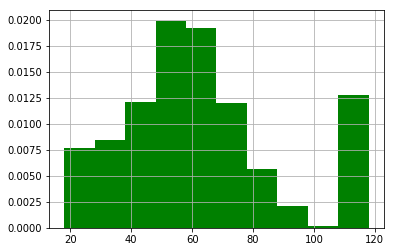

In [25]:
profile.age.hist(normed=1, color='green')

In [26]:
# View how many of each gender.
profile.gender.value_counts()

M    8484
F    6129
O     212
Name: gender, dtype: int64

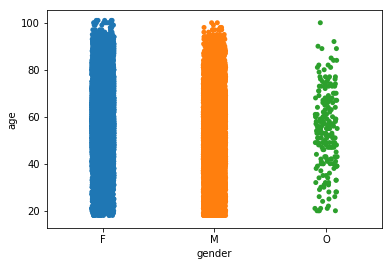

In [27]:
sns.stripplot(x='gender', y='age', data=profile, jitter=True)

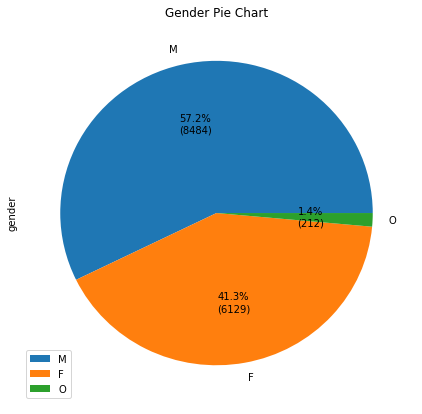

In [28]:
# Display Pie Chart of gender with % and value in the graph.
def autopct_label(pct, allvalues):
    """Recreate the value by multiplying the percentage by the total.
    
    Idea from https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html
    
    Args:
        pct (float) = percent for current piece of the pie.
        allvalues (Pandas Series): all values in the series.
    
    Returns:
        formatted string containing the % and the actual value.
    """
    absolute = int(np.round(pct/100. * np.sum(allvalues)))
    return f"{pct:.1f}%\n({absolute:d})"

profile.gender.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Gender Pie Chart", 
                                       autopct=lambda pct: autopct_label(pct, profile.gender.value_counts()), 
                                       legend=True)

In [29]:
# Lets check for null values
profile.isnull().sum()

gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64

In [30]:
# Lets check what % of data is missing in each column
profile.isnull().sum() * 100 / profile.shape[0]

gender              12.794118
age                  0.000000
id                   0.000000
became_member_on     0.000000
income              12.794118
dtype: float64

We can see the null values in income and gender

Text(0,0.5,'age of profile')

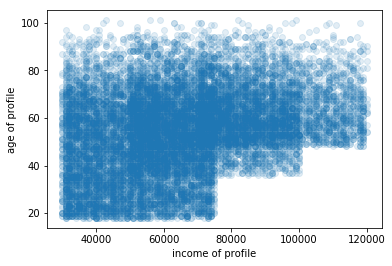

In [31]:
plt.scatter(data = profile, x = 'income', y = 'age', alpha = 1/8)
plt.xlabel('income of profile')
plt.ylabel('age of profile')

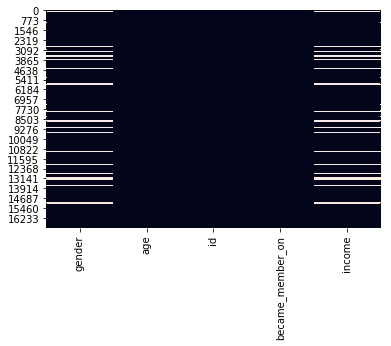

In [32]:
sns.heatmap(profile.isnull(), cbar=False)
plt.show()

In [33]:
profile.became_member_on.head()

0    20170212
1    20170715
2    20180712
3    20170509
4    20170804
Name: became_member_on, dtype: int64

Another observation the `became_member_on` column may be useful in feature engineering to get the duration of membership in days. This feature can help us measure the effectiveness of each offer.

In [34]:
profile.describe().transpose()

count          mean           std         min         25%  \
age               17000.0  6.253141e+01     26.738580        18.0        45.0   
became_member_on  17000.0  2.016703e+07  11677.499961  20130729.0  20160526.0   
income            14825.0  6.540499e+04  21598.299410     30000.0     49000.0   

                         50%         75%         max  
age                     58.0        73.0       118.0  
became_member_on  20170802.0  20171230.0  20180726.0  
income               64000.0     80000.0    120000.0

In [35]:
def distplot_plt(what_to_plot, plttitle, pltxlabel, pltylabel, pltxlim=100):
    fig= plt.subplots(figsize=(6,4))
    sns.distplot(what_to_plot, kde = False, bins=10, color = 'blue',
                 hist_kws={'edgecolor':'black'})
    plt.xlim(0, pltxlim)
    plt.xlim(left=-0.2)
    plt.title(plttitle,size = 20)
    plt.xlabel(pltxlabel, size =15)
    plt.ylabel(pltylabel, size =15)
    plt.show()

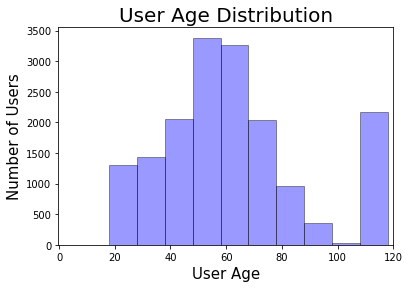

In [36]:
# Lets check what is the age distribution
distplot_plt(profile.age,'User Age Distribution','User Age','Number of Users', 120) 

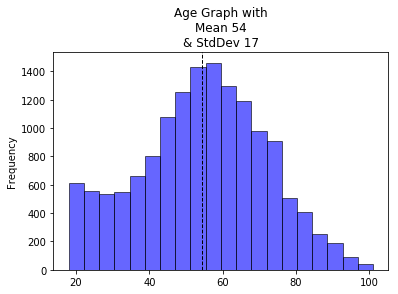

In [37]:
# Plot the ages (excluding the default age of 118) and also plot the mean line.
age_mean = profile[profile.age != 118].age.mean()
age_stddev = profile[profile.age != 118].age.std()
age_plot = profile[profile.age != 118].age.plot(kind='hist', 
                                                bins=20, 
                                                color='b', 
                                                edgecolor='k', 
                                                alpha=0.60,
                                                title=f"Age Graph with\nMean {int(age_mean)}\n& StdDev {int(age_stddev)}")
age_plot.axvline(age_mean, color='k', linestyle='dashed', linewidth=1)

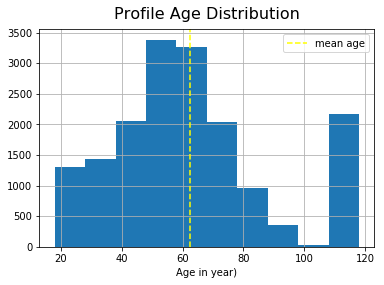

In [38]:
profile['age'].hist();
plt.axvline(profile['age'].mean(), color = 'Yellow', linestyle = '--', label = 'mean age')
plt.title('Profile Age Distribution', fontsize = 16, y = 1.02)
plt.xlabel('Age in year')
plt.legend()
plt.show()

User age of 118 does not make sense. We need to check if this match with the rest of the Null and drop later

In [39]:
profile[profile["age"]==118].count()

gender                 0
age                 2175
id                  2175
became_member_on    2175
income                 0
dtype: int64

In [40]:
profile[['age', 'gender', 'income']][profile["age"]==118].head(10)

age gender  income
0   118   None     NaN
2   118   None     NaN
4   118   None     NaN
6   118   None     NaN
7   118   None     NaN
9   118   None     NaN
10  118   None     NaN
11  118   None     NaN
17  118   None     NaN
23  118   None     NaN

In [41]:
print("Total ~{}% of Missing Data so we may cleanup later".format(round((2175*100)/17000), 2))

Total ~13% of Missing Data so we may cleanup later


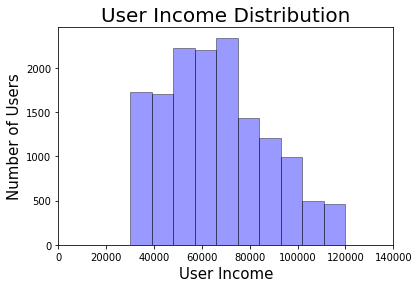

In [42]:
distplot_plt(profile.income.dropna(),'User Income Distribution','User Income','Number of Users', 140000) 

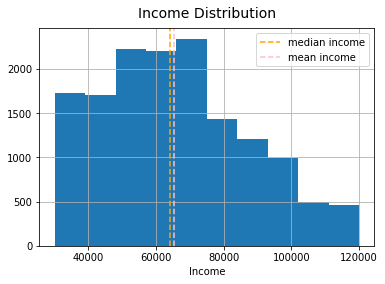

Median Income of the group: 64000.0
Mean Income of the group : 65405.0


In [43]:
profile['income'].hist();
plt.axvline(profile['income'].median(), color = 'orange', linestyle = '--', label = 'median income')
plt.axvline(profile['income'].mean(), color = 'pink', linestyle = '--', label = 'mean income')
plt.title('Income Distribution', fontsize = 14, y = 1.02)
plt.xlabel('Income')
plt.legend()
plt.show()

print('Median Income of the group: {}'.format(profile['income'].median()))
print('Mean Income of the group : {}'.format(round(profile['income'].mean(), 1)))

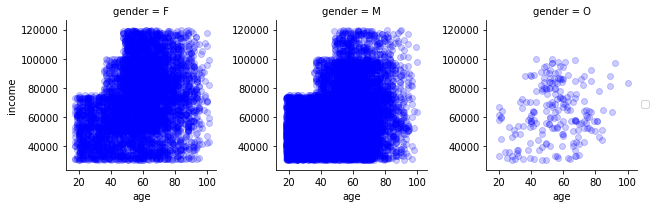

In [44]:
g = sns.FacetGrid(data = profile, col = 'gender')
g.map(plt.scatter, 'age', 'income', alpha=0.2, color = 'b');
g.add_legend();

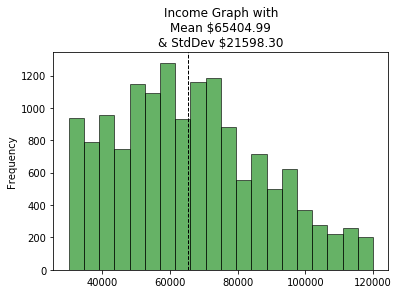

In [45]:
# Plot the incomes (excluding the NaN values) and also plot the mean line.
income_mean = profile.income.mean()
income_stddev = profile.income.std()
income_plot = profile.income.plot(kind='hist', 
                                  bins=20, 
                                  color='g', 
                                  edgecolor='k', 
                                  alpha=0.60, 
                                  title=f"Income Graph with\nMean ${income_mean:.2f}\n& StdDev ${income_stddev:.2f}")
income_plot.axvline(profile.income.mean(), color='k', linestyle='dashed', linewidth=1)

In [46]:
# Look at the earliest membership and the most recent membership dates.
print(f"Earliest membership is {profile.became_member_on.min()}")
print(f"Recent membership is {profile.became_member_on.max()}")

Earliest membership is 20130729
Recent membership is 20180726


### Transactional records

The schema for the transactional data is as follows:

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

#### Exploring Transcript.json - records for transactions, offers received, offers viewed, and offers completed

In [47]:
transcript.head(10)

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   
5  389bc3fa690240e798340f5a15918d5c  offer received   
6  c4863c7985cf408faee930f111475da3  offer received   
7  2eeac8d8feae4a8cad5a6af0499a211d  offer received   
8  aa4862eba776480b8bb9c68455b8c2e1  offer received   
9  31dda685af34476cad5bc968bdb01c53  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
5  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}     0  
6  {'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'}     0  
7  {'offer id': '3f207df678b143eea3cee63160fa8bed'}     0  
8  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
9  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0

In [48]:
transcript.sample(10).sort_values(by=['time'])

person           event  \
85259   cc251fdc5cc24936a741924a785ede5e    offer viewed   
102232  dac5cef904764a609e3a3b3d4f0058e8     transaction   
105597  df442eb2ce424dffb4eed96a6e33f2f4     transaction   
136612  9f83b1bf4fba46f48d0b1e1c63765f94     transaction   
159803  0a7ac081fbc147cf827c5df27db32f00  offer received   
170407  06e25a9a59f046de9aba0aa367613681    offer viewed   
198849  b93783eb826f47ad8c2d30dd8166ee17     transaction   
213066  b7dc974d1a5e4790b8e5eea0410efbf2  offer received   
237961  d3f70877b0ad4c909bce4f7960ba0f2c     transaction   
240697  76ec013980994d9d9ab7d077c326ef0a     transaction   

                                                   value  time  
85259   {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   210  
102232                                 {'amount': 17.49}   282  
105597                                  {'amount': 11.0}   300  
136612                                 {'amount': 29.52}   360  
159803  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}   408  
170407  {'offer id': 'f19421c1d4aa40978ebb69ca19b0e20d'}   414  
198849                                 {'amount': 13.34}   492  
213066  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}   504  
237961                                  {'amount': 0.56}   552  
240697                                  {'amount': 5.07}   558

In [49]:
transcript.shape

(306534, 4)

In [50]:
transcript['person'].nunique()

17000

Number of the unique Users on this dataset is same as with the number of Users in 'profile'.

In [51]:
# Lets check for null values
transcript.isnull().sum()

person    0
event     0
value     0
time      0
dtype: int64

As there are no null values in this dataset, to extract insights from the value column, we may have to expand the values into specific columns depending on the event.

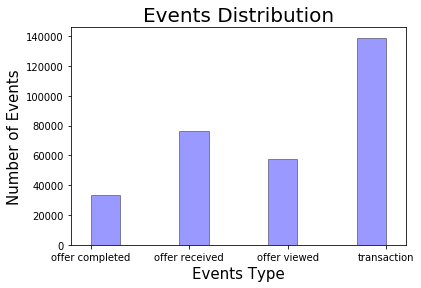

In [52]:
distplot_plt(transcript.event.dropna(),'Events Distribution','Events Type','Number of Events', 3.2) 

In [53]:
# See how many of each event occurred in the transcript.
transcript.event.value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [54]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

if you look at the data it is not clear, as it is ordered by time and has an event and value. This `value` column will have to be preprocessed depending on the event.

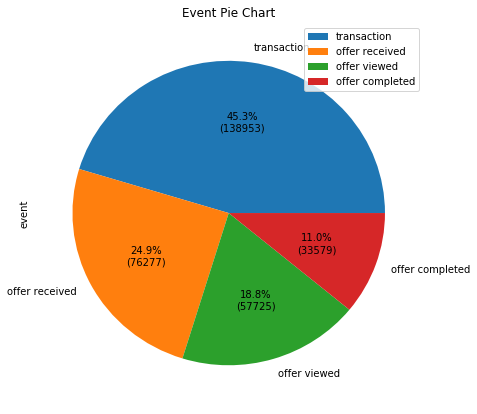

In [55]:
# Graph the event counts.
transcript.event.value_counts().plot.pie(figsize=(7, 7), 
                                       title="Event Pie Chart", 
                                       autopct=lambda pct: autopct_label(pct, transcript.event.value_counts()), 
                                       legend=True)

In [56]:
#To gain enough knowledge of the dataset,
#we shall find a completed offer which person, who viewed an offer after received and accepted the offer.

# Display few of the completed offers.
transcript[transcript.event == 'offer completed'].head(10)

person            event  \
12658  9fa9ae8f57894cc9a3b8a9bbe0fc1b2f  offer completed   
12672  fe97aa22dd3e48c8b143116a8403dd52  offer completed   
12679  629fc02d56414d91bca360decdfa9288  offer completed   
12692  676506bad68e4161b9bbaffeb039626b  offer completed   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   
12717  227f2d69e46a4899b70d48182822cff6  offer completed   
12721  bb0f25e23a4c4de6a645527c275cd594  offer completed   
12744  d72d201be5794279aa716d8ad82b8d90  offer completed   
12764  73ffefd41e9a4ca3ab26b2b3697c6eb7  offer completed   
12767  3e621194f72e40d7a0b695ee9b7c38b7  offer completed   

                                                   value  time  
12658  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
12672  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...     0  
12679  {'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...     0  
12692  {'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...     0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0  
12717  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0  
12721  {'offer_id': '2298d6c36e964ae4a3e7e9706d1fb8c2...     0  
12744  {'offer_id': 'f19421c1d4aa40978ebb69ca19b0e20d...     0  
12764  {'offer_id': '2906b810c7d4411798c6938adc9daaa5...     0  
12767  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0

In [57]:
# Look at a specific person.
transcript[transcript.person == '8f7dd3b2afe14c078eb4f6e6fe4ba97d'].head()

person            event  \
227    8f7dd3b2afe14c078eb4f6e6fe4ba97d   offer received   
12695  8f7dd3b2afe14c078eb4f6e6fe4ba97d     offer viewed   
12696  8f7dd3b2afe14c078eb4f6e6fe4ba97d      transaction   
12697  8f7dd3b2afe14c078eb4f6e6fe4ba97d  offer completed   
15605  8f7dd3b2afe14c078eb4f6e6fe4ba97d      transaction   

                                                   value  time  
227     {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
12695   {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  
12696                                  {'amount': 19.11}     0  
12697  {'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...     0  
15605                                  {'amount': 16.03}     6

In [58]:
# The first offer they completed by spending $19.11. 
#He/she received, viewed, and completed the offer on the same day.

# when we check the offer details.
# The discount offer was to spend $10 and receive a reward of $10.
portfolio[portfolio.id == '4d5c57ea9a6940dd891ad53e9dbe8da0']

reward                      channels  difficulty  duration offer_type  \
1      10  [web, email, mobile, social]          10         5       bogo   

                                 id  
1  4d5c57ea9a6940dd891ad53e9dbe8da0

In [59]:
transcript.head()

person           event  \
0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
1  a03223e636434f42ac4c3df47e8bac43  offer received   
2  e2127556f4f64592b11af22de27a7932  offer received   
3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
4  68617ca6246f4fbc85e91a2a49552598  offer received   

                                              value  time  
0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0

## Data preprocessing
#### Feature Engineering & Data Cleaning

### Portfolio.json Cleanup & Feature Engineering

#### Changes made:
- One-Hot Encode the channel list.
- One-Hot Encode offer_types.
- After encoding we drop 'channels' and 'offer_type' columns.
- Move the 'id' column to the first column, for display purposes.
- Rename 'id' to 'id_offer'

In [60]:
portfolio.head()

reward                      channels  difficulty  duration     offer_type  \
0      10       [email, mobile, social]          10         7           bogo   
1      10  [web, email, mobile, social]          10         5           bogo   
2       0          [web, email, mobile]           0         4  informational   
3       5          [web, email, mobile]           5         7           bogo   
4       5                  [web, email]          20        10       discount   

                                 id  
0  ae264e3637204a6fb9bb56bc8210ddfd  
1  4d5c57ea9a6940dd891ad53e9dbe8da0  
2  3f207df678b143eea3cee63160fa8bed  
3  9b98b8c7a33c4b65b9aebfe6a799e6d9  
4  0b1e1539f2cc45b7b9fa7c272da2e1d7

In [61]:
def channel_labels(row, chan):
    """Converting channel list into separate columns,
        with 1 indicating in the list, and 0 otherwise.
    
    Args:
        row (Pandas dataframe row) = current row.
        chan (str) = channel name.
    """
    if chan in row['channels']:
        return 1
    else:
        return 0

In [62]:
def move_id_to_first_col(p, inplace=True):
    """Moving the 'id' column to the first column for display purposes.
    Idea from https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas
    Args:
        p (Pandas dataframe) = dataframe to manipulate.
        inplace (bool) = if True, then don't make copy first. False, make copy.
    
    Returns:
        modified Pandas dataframe.
    """
    if inplace:
        p_copy = p
    else:
        p_copy = p.copy()
    
    # Geting list of the column names.
    cols = list(p_copy.columns)

    # Moveing id to start of the list
    cols.insert(0, cols.pop(cols.index('id')))

    # Reordering the columns
    p_copy = p_copy.loc[:, cols]
    
    # Returning p_copy
    return p_copy

In [63]:
def clean_portfolio_dataset():
    """Cleaning and performing Feature Engineering of portfolio dataframe.
    Returns:
        manipulated and cleaned Pandas dataframe.
    """
    # Creating a copy to make sure there are no issues later.
    p_copy = portfolio.copy()
    
    # One-Hot Encoding the channel_list
    for chan in ["email", "mobile", "social", "web"]:
        p_copy[chan] = p_copy.apply(lambda row: channel_labels(row, chan), axis=1)
    
    # Droping channels column
    p_copy.drop(columns=['channels'], inplace=True, axis=1)
    
    # One-Hot Encoding each offer_type
    for offer_type in set(p_copy.offer_type.values):
        p_copy[f"offer_{offer_type}"] = p_copy.apply(lambda row: 1 if row["offer_type"] == offer_type else 0, axis=1)
    
    # Droping offer_type column
    p_copy.drop(columns=['offer_type'], inplace=True, axis=1)
    
    # Moving "id" to be the first column, for display purposes.
    p_copy = move_id_to_first_col(p_copy)
    
    # Renaming "id" column to "id_offer".
    p_copy.rename(columns={'id': 'id_offer'}, inplace=True)
    
    # Returning p_copy
    return p_copy

In [64]:
# Shape before cleaning
print(f"Before performing cleaning, portfolio shape is {portfolio.shape}")

# Clean portfolio.
portfolio = clean_portfolio_dataset()

# Shape after cleaning
print(f"After performing cleaning, portfolio shape is {portfolio.shape}")

Before performing cleaning, portfolio shape is (10, 6)
After performing cleaning, portfolio shape is (10, 11)


In [65]:
# Confirm changes.
portfolio

id_offer  reward  difficulty  duration  email  \
0  ae264e3637204a6fb9bb56bc8210ddfd      10          10         7      1   
1  4d5c57ea9a6940dd891ad53e9dbe8da0      10          10         5      1   
2  3f207df678b143eea3cee63160fa8bed       0           0         4      1   
3  9b98b8c7a33c4b65b9aebfe6a799e6d9       5           5         7      1   
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       5          20        10      1   
5  2298d6c36e964ae4a3e7e9706d1fb8c2       3           7         7      1   
6  fafdcd668e3743c1bb461111dcafc2a4       2          10        10      1   
7  5a8bc65990b245e5a138643cd4eb9837       0           0         3      1   
8  f19421c1d4aa40978ebb69ca19b0e20d       5           5         5      1   
9  2906b810c7d4411798c6938adc9daaa5       2          10         7      1   

   mobile  social  web  offer_discount  offer_informational  offer_bogo  
0       1       1    0               0                    0           1  
1       1       1    1               0                    0           1  
2       1       0    1               0                    1           0  
3       1       0    1               0                    0           1  
4       0       0    1               1                    0           0  
5       1       1    1               1                    0           0  
6       1       1    1               1                    0           0  
7       1       1    0               0                    1           0  
8       1       1    1               0                    0           1  
9       1       0    1               1                    0           0

## Profile.json Feature Engineering

#### Changes made:
- Remove customers with missing data.
- Calculate the number of days customer has been a member.
- Store the year they became a member.
- Split the age into buckets by decade.
- One-Hot Encode each age range.
- One-Hot Encode gender.
- After encoding drop unused columns.
- Move 'id' column to the first column, and changed the name to 'id_customer'.

In [66]:
profile.head()

gender  age                                id  became_member_on    income
0   None  118  68be06ca386d4c31939f3a4f0e3dd783          20170212       NaN
1      F   55  0610b486422d4921ae7d2bf64640c50b          20170715  112000.0
2   None  118  38fe809add3b4fcf9315a9694bb96ff5          20180712       NaN
3      F   75  78afa995795e4d85b5d9ceeca43f5fef          20170509  100000.0
4   None  118  a03223e636434f42ac4c3df47e8bac43          20170804       NaN

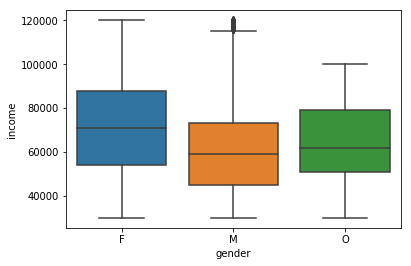

In [67]:
plt.figure(figsize=(6,4))
sns.boxplot(x = 'gender', y = 'income', data = profile)
plt.show()

Female members have higher average income compared to male members

In [68]:
def clean_profile():
    """Clean and perform Feature Engineering on the profile dataframe.
    
    Returns:
        manipulated Pandas dataframe.
    """
    # Creating a copy.
    p_copy = profile.copy()
    
    # Recall that above I found 2175 people had default values. Drop those values.
    p_copy.dropna(inplace=True)
    
    # Calculating number of days customer has been member and store in "membership_total_days".
    p_copy["membership_total_days"] = p_copy.became_member_on.apply(lambda dt: (datetime.today() - datetime.strptime(str(dt), "%Y%m%d")).days)
    
    # Storing the year they became member on.
    p_copy["membership_year"] = p_copy.became_member_on.apply(lambda dt: int(str(dt)[:4]))
    
    # Spliting (cut) age into buckets by decade. (10-19, 20-29, 30-39, etc.)
    # Removing the last digit, then multiply by 10 to get the minimum.
    min_age_bucket = int(profile.age.min()/10)*10
    
    # Removing the last digit, then multiply by 11 to get the maximum.
    # 11 because we want to include the full decade.
    
    max_age_bucket = int(profile.age.max()/10)*11
    
    # Spliting between the min and max bucket ages in groups of 10
    p_copy["age_range"] = pd.cut(p_copy["age"], range(min_age_bucket, max_age_bucket, 10), right=False)
    
    # One-Hot encoding each age_range.
    for age_range in sorted(set(p_copy.age_range.values)):
        p_copy[f"age_{age_range}"] = p_copy.apply(lambda row: 1 if row["age_range"] == age_range else 0, axis=1)
    
    # One-Hot encoding gender.
    for gender in set(p_copy.gender.values):
        p_copy[f"gender_{gender}"] = p_copy.apply(lambda row: 1 if row["gender"] == gender else 0, axis=1)
    
    # Droping the age, age_range, became_member_on, and gender columns.
    p_copy.drop(columns=['age', 'age_range', 'became_member_on', 'gender'], inplace=True, axis=1)
    
    # Moving "id" to be the first column, for display purposes.
    p_copy = move_id_to_first_col(p_copy)
    
    p_copy.rename(columns={'id': 'id_customer'}, inplace=True)
    
    # Return p_copy
    return p_copy

In [69]:
# dataframe shape before cleaning
print(f"Before cleaning, profile has shape {profile.shape}")

profile = clean_profile()

# dataframe shape after cleaning
print(f"After cleaning, profile has shape {profile.shape}")

Before cleaning, profile has shape (17000, 5)
After cleaning, profile has shape (14825, 17)


In [70]:
# investigating the changes
profile.head()

id_customer    income  membership_total_days  \
1   0610b486422d4921ae7d2bf64640c50b  112000.0                   1025   
3   78afa995795e4d85b5d9ceeca43f5fef  100000.0                   1092   
5   e2127556f4f64592b11af22de27a7932   70000.0                    740   
8   389bc3fa690240e798340f5a15918d5c   53000.0                    816   
12  2eeac8d8feae4a8cad5a6af0499a211d   51000.0                    906   

    membership_year  age_[10, 20)  age_[20, 30)  age_[30, 40)  age_[40, 50)  \
1              2017             0             0             0             0   
3              2017             0             0             0             0   
5              2018             0             0             0             0   
8              2018             0             0             0             0   
12             2017             0             0             0             0   

    age_[50, 60)  age_[60, 70)  age_[70, 80)  age_[80, 90)  age_[90, 100)  \
1              1             0             0             0              0   
3              0             0             1             0              0   
5              0             1             0             0              0   
8              0             1             0             0              0   
12             1             0             0             0              0   

    age_[100, 110)  gender_O  gender_M  gender_F  
1                0         0         0         1  
3                0         0         0         1  
5                0         0         1         0  
8                0         0         1         0  
12               0         0         1         0

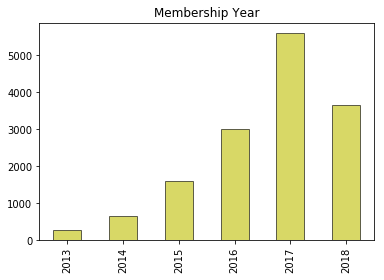

In [71]:
# Ploting the number of memberships per year.
# It is increasing every year.  The data only contains up to 20180726,
# 2018 data is a little over halfway available
membership_year_plot = profile.membership_year.value_counts().sort_index().plot(kind='bar',
                                  color='y', 
                                  edgecolor='k', 
                                  alpha=0.60, 
                                  title=f"Membership Year")

## Transcript.json Feature Engineering process

#### Changes made:
- Rename 'person' column to 'id_customer'.
- One-Hot encode events
- Get 'offer id' from the 'value' column dictionary and place it in the new column.
- Get 'amount' from the 'value' column dictionary and place it in the new column.
- Now drop unused columns

In [72]:
transcript.tail(10)

person            event  \
306524  d613ca9c59dd42f497bdbf6178da54a7      transaction   
306525  eec70ab28af74a22a4aeb889c0317944      transaction   
306526  24f56b5e1849462093931b164eb803b5      transaction   
306527  24f56b5e1849462093931b164eb803b5  offer completed   
306528  5ca2620962114246ab218fc648eb3934      transaction   
306529  b3a1272bc9904337b331bf348c3e8c17      transaction   
306530  68213b08d99a4ae1b0dcb72aebd9aa35      transaction   
306531  a00058cf10334a308c68e7631c529907      transaction   
306532  76ddbd6576844afe811f1a3c0fbb5bec      transaction   
306533  c02b10e8752c4d8e9b73f918558531f7      transaction   

                                                    value  time  
306524                                  {'amount': 25.14}   714  
306525                                  {'amount': 43.58}   714  
306526                                  {'amount': 22.64}   714  
306527  {'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...   714  
306528                                    {'amount': 2.2}   714  
306529                     {'amount': 1.5899999999999999}   714  
306530                                   {'amount': 9.53}   714  
306531                                   {'amount': 3.61}   714  
306532                     {'amount': 3.5300000000000002}   714  
306533                                   {'amount': 4.05}   714

In [73]:
transcript.dtypes

person    object
event     object
value     object
time       int64
dtype: object

In [74]:
transcript.value.values

array([{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},
       {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},
       {'offer id': '2906b810c7d4411798c6938adc9daaa5'}, ...,
       {'amount': 3.61}, {'amount': 3.5300000000000002}, {'amount': 4.05}],
      dtype=object)

In [75]:
# Get list of unique keys in the 'value' column dictionary
set_of_value_keys = {k for item in transcript.value.values for k in item.keys()}

# Upon investigation, it appears when events are completed the value dict
# contains both 'offer_id' and 'reward'.
# We do not need 'reward' since that is the same 'reward' from the 'portfolio'.
print(f"Found the following keys in the 'values' column:\n{set_of_value_keys}")

Found the following keys in the 'values' column:
{'offer_id', 'reward', 'amount', 'offer id'}


In [76]:
def getOfferFromTranscript(d):
    """Given dictionary, get the offer from it (if present)."""
    if "offer id" in d:
        return d["offer id"]
    elif "offer_id" in d:
        return d["offer_id"]
    else:
        return np.nan

def getAmountFromTranscript(d):
    """Given dictionary, get the amount from it (if present)."""
    if "amount" in d:
        return d["amount"]
    else:
        return np.nan

In [77]:
def clean_transcript():
    """Cleaning and performing Feature Engineering of the transcript dataframe.
    
    Returns:
        cleaned and manipulated transcript dataframe.
    """
    # Creating a backup copy to avoid errors later
    p_copy = transcript.copy()
    
    # Rename "person" to be "id_customer" to match Profile dataframe.
    p_copy.rename(columns={'person': 'id_customer'}, inplace=True)
    
    # Since we dropped the N/A rows from profile, need to also drop all transactions
    # pertaining to that customer.
    p_copy = p_copy[p_copy.id_customer.isin(profile.id_customer.values)]
    
    # One-Hot encode event.
    for event in set(p_copy.event.values):
        p_copy[f"event_{event}"] = p_copy.apply(lambda row: 1 if row["event"] == event else 0, axis=1)
    
    # Getting 'offer id' from value column dictionary and place in new column.
    p_copy["id_offer"] = p_copy.value.apply(lambda v: getOfferFromTranscript(v))
    
    # Getting 'amount' from value column dictionary and place in new column.
    p_copy["trans_amt"] = p_copy.value.apply(lambda v: getAmountFromTranscript(v))
    
    # Droping unused columns
    p_copy.drop(columns=['event', 'value'], inplace=True, axis=1)
    
    # Converting all spaces in column names to _
    p_copy.columns = [s.replace(" ", "_") for s in p_copy.columns]
        
    # Return p_copy
    return p_copy

In [78]:
# Shape before cleaning
print(f"Before cleaning, transcript has shape {transcript.shape}")

transcript = clean_transcript()

# Shape after cleaning
print(f"After cleaning, transcript has shape {transcript.shape}")

Before cleaning, transcript has shape (306534, 4)
After cleaning, transcript has shape (272762, 8)


In [79]:
transcript.head(10)

id_customer  time  event_transaction  \
0   78afa995795e4d85b5d9ceeca43f5fef     0                  0   
2   e2127556f4f64592b11af22de27a7932     0                  0   
5   389bc3fa690240e798340f5a15918d5c     0                  0   
7   2eeac8d8feae4a8cad5a6af0499a211d     0                  0   
8   aa4862eba776480b8bb9c68455b8c2e1     0                  0   
9   31dda685af34476cad5bc968bdb01c53     0                  0   
12  4b0da7e80e5945209a1fdddfe813dbe0     0                  0   
13  c27e0d6ab72c455a8bb66d980963de60     0                  0   
14  d53717f5400c4e84affdaeda9dd926b3     0                  0   
15  f806632c011441378d4646567f357a21     0                  0   

    event_offer_viewed  event_offer_completed  event_offer_received  \
0                    0                      0                     1   
2                    0                      0                     1   
5                    0                      0                     1   
7                    0                      0                     1   
8                    0                      0                     1   
9                    0                      0                     1   
12                   0                      0                     1   
13                   0                      0                     1   
14                   0                      0                     1   
15                   0                      0                     1   

                            id_offer  trans_amt  
0   9b98b8c7a33c4b65b9aebfe6a799e6d9        NaN  
2   2906b810c7d4411798c6938adc9daaa5        NaN  
5   f19421c1d4aa40978ebb69ca19b0e20d        NaN  
7   3f207df678b143eea3cee63160fa8bed        NaN  
8   0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
9   0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
12  ae264e3637204a6fb9bb56bc8210ddfd        NaN  
13  3f207df678b143eea3cee63160fa8bed        NaN  
14  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
15  fafdcd668e3743c1bb461111dcafc2a4        NaN

In [80]:
transcript.tail(10)

id_customer  time  event_transaction  \
306522  d1c4500ace2e45e9a45d3cd2fccac8d8   714                  1   
306523  b65affd9e07346a1906364a396950e3d   714                  1   
306524  d613ca9c59dd42f497bdbf6178da54a7   714                  1   
306525  eec70ab28af74a22a4aeb889c0317944   714                  1   
306526  24f56b5e1849462093931b164eb803b5   714                  1   
306527  24f56b5e1849462093931b164eb803b5   714                  0   
306529  b3a1272bc9904337b331bf348c3e8c17   714                  1   
306530  68213b08d99a4ae1b0dcb72aebd9aa35   714                  1   
306531  a00058cf10334a308c68e7631c529907   714                  1   
306532  76ddbd6576844afe811f1a3c0fbb5bec   714                  1   

        event_offer_viewed  event_offer_completed  event_offer_received  \
306522                   0                      0                     0   
306523                   0                      0                     0   
306524                   0                      0                     0   
306525                   0                      0                     0   
306526                   0                      0                     0   
306527                   0                      1                     0   
306529                   0                      0                     0   
306530                   0                      0                     0   
306531                   0                      0                     0   
306532                   0                      0                     0   

                                id_offer  trans_amt  
306522                               NaN       4.42  
306523                               NaN      18.35  
306524                               NaN      25.14  
306525                               NaN      43.58  
306526                               NaN      22.64  
306527  fafdcd668e3743c1bb461111dcafc2a4        NaN  
306529                               NaN       1.59  
306530                               NaN       9.53  
306531                               NaN       3.61  
306532                               NaN       3.53

Performing checks regarding if a customer received the same offer multiple times

In [81]:
# Checking if any customer has received the same offer multiple times.
cust_offer_ids = transcript.apply(lambda row: f"{row['id_customer']}_{row['id_offer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [82]:
# Checking the counts and see that some customers did receive the same offer multiple times.
cust_offer_ids.value_counts()

eece6a9a7bdd4ea1b0f812f34fc619d6_5a8bc65990b245e5a138643cd4eb9837    5
23d67a23296a485781e69c109a10a1cf_5a8bc65990b245e5a138643cd4eb9837    5
43a50d7e5c8547a9aa1ec31291b9fc30_0b1e1539f2cc45b7b9fa7c272da2e1d7    5
6d2db3aad94648259e539920fc2cf2a6_f19421c1d4aa40978ebb69ca19b0e20d    5
e008262ad24e46af98a928342e303c3e_2298d6c36e964ae4a3e7e9706d1fb8c2    4
                                                                    ..
bc9967a6750e496ab469784ce225ade2_2298d6c36e964ae4a3e7e9706d1fb8c2    1
d655397f93744375b4674b0af19ee281_5a8bc65990b245e5a138643cd4eb9837    1
7308c738e39b4e4e9b6beec61ef4cf3c_2298d6c36e964ae4a3e7e9706d1fb8c2    1
625d12f6c0ff481ca23ebefddd0e8d0a_2298d6c36e964ae4a3e7e9706d1fb8c2    1
a4e324a32bad4aee8eca0db182dabc24_f19421c1d4aa40978ebb69ca19b0e20d    1
Length: 55222, dtype: int64

In [83]:
# Look at the first entry and see the same was received 5 times by the same customer.
transcript[(transcript.event_offer_received) & (transcript.id_customer == "43a50d7e5c8547a9aa1ec31291b9fc30") & (transcript.id_offer == "0b1e1539f2cc45b7b9fa7c272da2e1d7")]

id_customer  time  event_transaction  \
5619    43a50d7e5c8547a9aa1ec31291b9fc30     0                  0   
58837   43a50d7e5c8547a9aa1ec31291b9fc30   168                  0   
118032  43a50d7e5c8547a9aa1ec31291b9fc30   336                  0   
155682  43a50d7e5c8547a9aa1ec31291b9fc30   408                  0   
250751  43a50d7e5c8547a9aa1ec31291b9fc30   576                  0   

        event_offer_viewed  event_offer_completed  event_offer_received  \
5619                     0                      0                     1   
58837                    0                      0                     1   
118032                   0                      0                     1   
155682                   0                      0                     1   
250751                   0                      0                     1   

                                id_offer  trans_amt  
5619    0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
58837   0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
118032  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
155682  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN  
250751  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN

In [84]:
# understanding a specific offer.
portfolio[portfolio.id_offer == "0b1e1539f2cc45b7b9fa7c272da2e1d7"]

id_offer  reward  difficulty  duration  email  \
4  0b1e1539f2cc45b7b9fa7c272da2e1d7       5          20        10      1   

   mobile  social  web  offer_discount  offer_informational  offer_bogo  
4       0       0    1               1                    0           0

In [85]:
# verifying if received same offer at same time stamp multiple times.
ts_cust_offer_ids = transcript.apply(lambda row: f"{row['time']}_{row['id_customer']}_{row['id_offer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [86]:
# check only one of the same offer at a time
ts_cust_offer_ids.value_counts()

408_03b0358ba8d945b3ac283f25969a0cca_f19421c1d4aa40978ebb69ca19b0e20d    1
336_5115fdb314fe41619fda3e5d8060a8b5_2906b810c7d4411798c6938adc9daaa5    1
408_4a63ea5abbb1401e877d73e7e9398e13_ae264e3637204a6fb9bb56bc8210ddfd    1
168_2c849dc4ca6d4d4f8510804723fc5dac_fafdcd668e3743c1bb461111dcafc2a4    1
168_e5321ed1b91147fa9b9726216bc132ce_5a8bc65990b245e5a138643cd4eb9837    1
                                                                        ..
408_345b2431ce28457b97e7492506803d2e_2906b810c7d4411798c6938adc9daaa5    1
576_0e18338db3524564870a52ee5cfe68a4_3f207df678b143eea3cee63160fa8bed    1
576_69ba4dacbb2d4421ba1edf46197122f8_4d5c57ea9a6940dd891ad53e9dbe8da0    1
168_a68b9966964240caa919b0c08c201904_2298d6c36e964ae4a3e7e9706d1fb8c2    1
0_339ce280165b40cb856d943db119499a_fafdcd668e3743c1bb461111dcafc2a4      1
Length: 66501, dtype: int64

In [87]:
# Checking if customer received multiple offers at same timestamp or not?
ts_cust_ids = transcript.apply(lambda row: f"{row['time']}_{row['id_customer']}" if (row['event_offer_received']) else np.nan, axis=1)

In [88]:
# analysing sustomers only received single offer at a single timestamp.
ts_cust_ids.value_counts()

168_bb8076bc030e4fd8a90798217906505f    1
576_877863724c474a61a11755c97640f48d    1
168_5da06c89165842058885d81018a7ced6    1
504_80c8a3abd35c47baafb20b4f0fc8702d    1
504_5914d17eefa641a29579c972d2b29e60    1
                                       ..
336_22fb7286392241b5a8c92be7a23a04a9    1
576_47849ffd86e34e40a763bb66ad81fbb1    1
336_759ec3a510e84d9598cf238f719dbda5    1
504_fc2cf70b22fe494d9c7be20329b9754e    1
168_e89343c8b43040e1a55945cd6cba387f    1
Length: 66501, dtype: int64

In [89]:
def offer_dict_factory():
    """Factory used for creating default dictionary with the following keys:
    
    # Keep counters of events for this offer.
    -'num_times_received' (int) = Keep track of number of times customer has received this offer.
    -'num_times_viewed' (int) = Keep track of number of times customer has viewed this offer.
    -'num_times_completed' (int) = Keep track of number of times customer has completed this offer.
    
    # Amount spent.
    -'total_amt_spent_toward_offer' (float) = total amount spent from when offer received until it expires.
    
    """
    return {
        'num_times_received': 0,
        'num_times_viewed': 0,
        'num_times_completed': 0,
        'total_amt_spent_toward_offer': 0.0
    }

def cust_dict_factory():
    """Factory used for creating default dictionary with the following keys:
    
    -'active_offers' (dict) = key of active id_offer's and value of expiration timestamp.
            If we were to receive another of the same offer before the previous one expired,
            we would just update the value for the new offer.
    -'offers' (dict) = key is 'id_offer' and dict from offer_dict_factory.
    -'total_amt_spent_not_in_offer' (float) = Total amount customer spent not associated with any offer.
    
    """
    return {
        'active_offers': {},  # dict with key of active id_offer's and value of expiration timestamp.
        'offers': defaultdict(lambda: offer_dict_factory()),  # dict holding details of all offers.
        'total_amt_spent_not_in_offer': 0.0
    }

# Helper function to hold difficulty and duration for each offer
offer_difficulty = {l[0]: l[1] for l in portfolio.loc[:, ['id_offer', 'difficulty']].values}
offer_duration = {l[0]: l[1] for l in portfolio.loc[:, ['id_offer', 'duration']].values}

# to initialize customer offer dictionary
cust_offer_dict = defaultdict(lambda: cust_dict_factory())

# Iterate over the rows.
# Per this article, itertuples is significantly faster than iterrows:
# https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d
for row in transcript.itertuples(index=False):
    # Store values from row for easy access.
    timestamp = row.time
    cust_id = row.id_customer
    offer_id = row.id_offer
    offer_rcvd = row.event_offer_received
    offer_view = row.event_offer_viewed
    offer_complete = row.event_offer_completed
    transaction = row.event_transaction
    amt = row.trans_amt
    
    # Check if any offers for customer have expired and remove from 'active_offers'.
    expired_offers = [k for k,v in cust_offer_dict[cust_id]['active_offers'].items() if timestamp > v]
    if expired_offers:
        # Offers have expired.
        # Remove them from 'active_offers'.
        for exp in expired_offers:
            del cust_offer_dict[cust_id]['active_offers'][exp]
    
    
    # Going through each event type.
    if offer_rcvd:
        # Received the offer.
        # Add offer to 'active_offers' with expiration timestamp.
        # Check if multiple offers are active at the same time and display WARNING message.
        # Update 'num_times_received' in 'offers' dict. Since defaultdict, it will create it if not already present.

        # Add offer to 'active_offers' with value as the expiration time.
        # - timestamp is in hours.
        # - duration is in days.
        # - Need to convert expiration to be in hours.
        expiration_time = timestamp + (offer_duration[offer_id] * 24)
        cust_offer_dict[cust_id]['active_offers'][offer_id] = expiration_time
        
        # Verify we do not have multiple offers active at the same time.
        if len(cust_offer_dict[cust_id]['active_offers']) > 1:
            print(f"WARNING: Multiple offers active for customer {cust_id}: {cust_offer_dict[cust_id]['active_offers']}")
        
        # Update number of times received.
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_received'] += 1
        
    elif offer_view:
        # Viewed the offer.
        # Update 'num_times_viewed'.
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_viewed'] += 1
    
    elif offer_complete:
        # Completed offer.
        # Update 'num_times_completed'
        cust_offer_dict[cust_id]['offers'][offer_id]['num_times_completed'] += 1
    
    elif transaction:
        # Check if any active offers.
        if cust_offer_dict[cust_id]['active_offers']:
            # Update 'total_amt_spent_toward_offer'
            for offer in cust_offer_dict[cust_id]['active_offers'].keys():
                cust_offer_dict[cust_id]['offers'][offer]['total_amt_spent_toward_offer'] += amt
        else:
            # No active offer.
            # Update 'total_amt_spent_not_in_offer'.
            cust_offer_dict[cust_id]['total_amt_spent_not_in_offer'] += amt

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [90]:
# Print the dictionary we built.
cust_offer_dict

defaultdict(<function __main__.<lambda>()>,
            {'78afa995795e4d85b5d9ceeca43f5fef': {'active_offers': {'f19421c1d4aa40978ebb69ca19b0e20d': 624},
              'offers': defaultdict(<function __main__.cust_dict_factory.<locals>.<lambda>()>,
                          {'9b98b8c7a33c4b65b9aebfe6a799e6d9': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 1,
                            'total_amt_spent_toward_offer': 37.67},
                           '5a8bc65990b245e5a138643cd4eb9837': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 0,
                            'total_amt_spent_toward_offer': 49.39},
                           'ae264e3637204a6fb9bb56bc8210ddfd': {'num_times_received': 1,
                            'num_times_viewed': 1,
                            'num_times_completed': 1,
                            'tota

In [91]:
# Go through 'profile' and 'transcript' and add new columns for each key of cust_offer_dict (and keys of 'offers')
profile['amount_spent_not_in_offer'] = profile.apply(lambda row: cust_offer_dict[row['id_customer']]['total_amt_spent_not_in_offer'], axis=1)

transcript['num_times_received'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'], axis=1)
transcript['num_times_viewed'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_viewed'], axis=1)
transcript['num_times_completed'] = transcript.apply(lambda row: 
                                                    cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_completed'], axis=1)
transcript['total_amt_spent_towards_offer'] = transcript.apply(lambda row: 
                                                    np.round(cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['total_amt_spent_toward_offer'], decimals=2), axis=1)
transcript['avg_amt_spent_towards_offer'] = transcript.apply(lambda row: 
                                                    np.round(cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['total_amt_spent_toward_offer'] / cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'], decimals=2)
                                                             if cust_offer_dict[row['id_customer']]['offers'][row['id_offer']]['num_times_received'] else 0, axis=1)

In [92]:
profile.head()

id_customer    income  membership_total_days  \
1   0610b486422d4921ae7d2bf64640c50b  112000.0                   1025   
3   78afa995795e4d85b5d9ceeca43f5fef  100000.0                   1092   
5   e2127556f4f64592b11af22de27a7932   70000.0                    740   
8   389bc3fa690240e798340f5a15918d5c   53000.0                    816   
12  2eeac8d8feae4a8cad5a6af0499a211d   51000.0                    906   

    membership_year  age_[10, 20)  age_[20, 30)  age_[30, 40)  age_[40, 50)  \
1              2017             0             0             0             0   
3              2017             0             0             0             0   
5              2018             0             0             0             0   
8              2018             0             0             0             0   
12             2017             0             0             0             0   

    age_[50, 60)  age_[60, 70)  age_[70, 80)  age_[80, 90)  age_[90, 100)  \
1              1             0             0             0              0   
3              0             0             1             0              0   
5              0             1             0             0              0   
8              0             1             0             0              0   
12             1             0             0             0              0   

    age_[100, 110)  gender_O  gender_M  gender_F  amount_spent_not_in_offer  
1                0         0         0         1                      53.79  
3                0         0         0         1                      23.93  
5                0         0         1         0                      39.31  
8                0         0         1         0                       0.00  
12               0         0         1         0                       0.00

In [93]:
transcript.head()

id_customer  time  event_transaction  \
0  78afa995795e4d85b5d9ceeca43f5fef     0                  0   
2  e2127556f4f64592b11af22de27a7932     0                  0   
5  389bc3fa690240e798340f5a15918d5c     0                  0   
7  2eeac8d8feae4a8cad5a6af0499a211d     0                  0   
8  aa4862eba776480b8bb9c68455b8c2e1     0                  0   

   event_offer_viewed  event_offer_completed  event_offer_received  \
0                   0                      0                     1   
2                   0                      0                     1   
5                   0                      0                     1   
7                   0                      0                     1   
8                   0                      0                     1   

                           id_offer  trans_amt  num_times_received  \
0  9b98b8c7a33c4b65b9aebfe6a799e6d9        NaN                   1   
2  2906b810c7d4411798c6938adc9daaa5        NaN                   1   
5  f19421c1d4aa40978ebb69ca19b0e20d        NaN                   2   
7  3f207df678b143eea3cee63160fa8bed        NaN                   1   
8  0b1e1539f2cc45b7b9fa7c272da2e1d7        NaN                   1   

   num_times_viewed  num_times_completed  total_amt_spent_towards_offer  \
0                 1                    1                          37.67   
2                 1                    0                           0.00   
5                 2                    2                          20.80   
7                 0                    0                           0.00   
8                 1                    0                          12.33   

   avg_amt_spent_towards_offer  
0                        37.67  
2                         0.00  
5                        10.40  
7                         0.00  
8                        12.33

In [94]:
# Shape before secondary cleaning
print(f"Before secondary cleaning, transcript has shape {transcript.shape}")

# I can now drop multiple columns from transcript.
transcript.drop(columns=['time', 'event_offer_completed', 'event_transaction', 
                        'event_offer_received', 'event_offer_viewed', 'trans_amt'], inplace=True, axis=1)

transcript.drop_duplicates(inplace=True)

# Shape after secondary cleaning
print(f"After secondary cleaning, transcript has shape {transcript.shape}")

Before secondary cleaning, transcript has shape (272762, 13)
After secondary cleaning, transcript has shape (69714, 7)


In [95]:
# Check how many customers did not receive any offers.
print(f"There are {len([c for c in cust_offer_dict.keys() if not len(cust_offer_dict[c]['offers'])])} customers that did NOT receive an offer.")
# Therefore, every customer received at least one offer.

# Check the counts of offers sent to customers.
print(f"The counts of offers sent to customers were: {set([len(cust_offer_dict[c]['offers']) for c in cust_offer_dict.keys()])}")
# Therefore, between 1-7 offers were sent to each customer.

There are 0 customers that did NOT receive an offer.
The counts of offers sent to customers were: {1, 2, 3, 4, 5, 6, 7}


## Merge or Combine Dataset

#### Changes made:
- Combine all the datasets.
- Iterate over transcript data for each customer.
   - When an offer is received, get the total amount purchased within the time duration for that customer and offer.
- For each offer we can look at a specific customer to see:
   - How much money the customer spent on offer?
   - Did they view the offer? Did they complete the offer?

In [96]:
# Merge them together.
combined = pd.merge(transcript, portfolio, how='left', on="id_offer")
combined = pd.merge(combined, profile, how='left', on="id_customer")

In [97]:
combined.head(10)

id_customer                          id_offer  \
0  78afa995795e4d85b5d9ceeca43f5fef  9b98b8c7a33c4b65b9aebfe6a799e6d9   
1  e2127556f4f64592b11af22de27a7932  2906b810c7d4411798c6938adc9daaa5   
2  389bc3fa690240e798340f5a15918d5c  f19421c1d4aa40978ebb69ca19b0e20d   
3  2eeac8d8feae4a8cad5a6af0499a211d  3f207df678b143eea3cee63160fa8bed   
4  aa4862eba776480b8bb9c68455b8c2e1  0b1e1539f2cc45b7b9fa7c272da2e1d7   
5  31dda685af34476cad5bc968bdb01c53  0b1e1539f2cc45b7b9fa7c272da2e1d7   
6  4b0da7e80e5945209a1fdddfe813dbe0  ae264e3637204a6fb9bb56bc8210ddfd   
7  c27e0d6ab72c455a8bb66d980963de60  3f207df678b143eea3cee63160fa8bed   
8  d53717f5400c4e84affdaeda9dd926b3  0b1e1539f2cc45b7b9fa7c272da2e1d7   
9  f806632c011441378d4646567f357a21  fafdcd668e3743c1bb461111dcafc2a4   

   num_times_received  num_times_viewed  num_times_completed  \
0                   1                 1                    1   
1                   1                 1                    0   
2                   2                 2                    2   
3                   1                 0                    0   
4                   1                 1                    0   
5                   1                 1                    0   
6                   2                 2                    1   
7                   2                 2                    0   
8                   2                 2                    2   
9                   2                 2                    2   

   total_amt_spent_towards_offer  avg_amt_spent_towards_offer  reward  \
0                          37.67                        37.67     5.0   
1                           0.00                         0.00     2.0   
2                          20.80                        10.40     5.0   
3                           0.00                         0.00     0.0   
4                          12.33                        12.33     5.0   
5                           0.00                         0.00     5.0   
6                          31.05                        15.52    10.0   
7                          68.46                        34.23     0.0   
8                         420.46                       210.23     5.0   
9                          75.38                        37.69     2.0   

   difficulty  duration  ...  age_[50, 60)  age_[60, 70)  age_[70, 80)  \
0         5.0       7.0  ...             0             0             1   
1        10.0       7.0  ...             0             1             0   
2         5.0       5.0  ...             0             1             0   
3         0.0       4.0  ...             1             0             0   
4        20.0      10.0  ...             0             1             0   
5        20.0      10.0  ...             0             1             0   
6        10.0       7.0  ...             0             1             0   
7         0.0       4.0  ...             0             0             1   
8        20.0      10.0  ...             0             0             0   
9        10.0      10.0  ...             0             0             0   

   age_[80, 90)  age_[90, 100)  age_[100, 110)  gender_O  gender_M  gender_F  \
0             0              0               0         0         0         1   
1             0              0               0         0         1         0   
2             0              0               0         0         1         0   
3             0              0               0         0         1         0   
4             0              0               0         0         0         1   
5             0              0               0         0         0         1   
6             0              0               0         0         1         0   
7             0              0               0         0         0         1   
8             1              0               0         0         0         1   
9             0              0               0         0         1         0   

   amount_spent

In [98]:
combined.columns

Index(['id_customer', 'id_offer', 'num_times_received', 'num_times_viewed',
       'num_times_completed', 'total_amt_spent_towards_offer',
       'avg_amt_spent_towards_offer', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'offer_discount',
       'offer_informational', 'offer_bogo', 'income', 'membership_total_days',
       'membership_year', 'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)',
       'age_[40, 50)', 'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)',
       'age_[80, 90)', 'age_[90, 100)', 'age_[100, 110)', 'gender_O',
       'gender_M', 'gender_F', 'amount_spent_not_in_offer'],
      dtype='object')

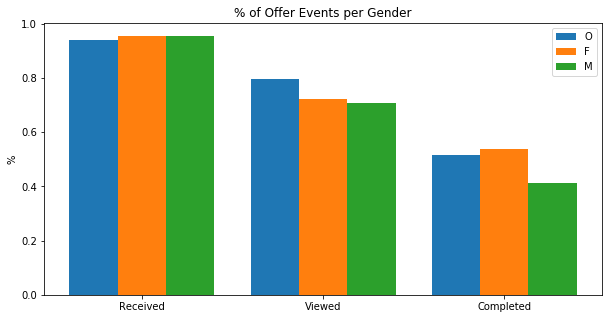

In [99]:
# Ideas from:
# https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/1/ch01lvl1sec16/plotting-multiple-bar-charts
# https://matplotlib.org/3.1.1/gallery/units/bar_unit_demo.html
def getOffersPerGenderData(gender):
    """Get data for number of offers received/viewed/completed per gender.
    
    Args:
        -gender (str) = M, F, or O.
    
    Returns:
        -list containing percentage based on number of offer event per gender / total number of gender.
    """
    # Initialize list to hold data for graph.
    data = []
    
    for x in ['num_times_received', 'num_times_viewed', 'num_times_completed']:
        data.append(combined.groupby(by=f"gender_{gender}")[x].sum()[1] / combined.groupby(by=f"gender_{gender}")[f"gender_{gender}"].sum()[1])
    
    return data

def graphOffersPerGender():
    """this is a graph total number of offers received/viewed/completed per gender.
    """
    # checking List of lists containing data for all genders.
    all_data = [getOffersPerGenderData('O'), getOffersPerGenderData('F'), getOffersPerGenderData('M')]

    f, ax = plt.subplots()
    f.set_figheight(5)
    f.set_figwidth(10)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(['O', 'F', 'M'])
        ax.set_title('% of Offer Events per Gender')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Received', 'Viewed', 'Completed'))
        ax.set_ylabel("%")
        # Some example data to display

graphOffersPerGender()

From this we see that `received` was fairly even for all genders.

Majority of all genders `viewed`.

Roughly half of Other and Female `completed`. Less than half of Males `completed`.

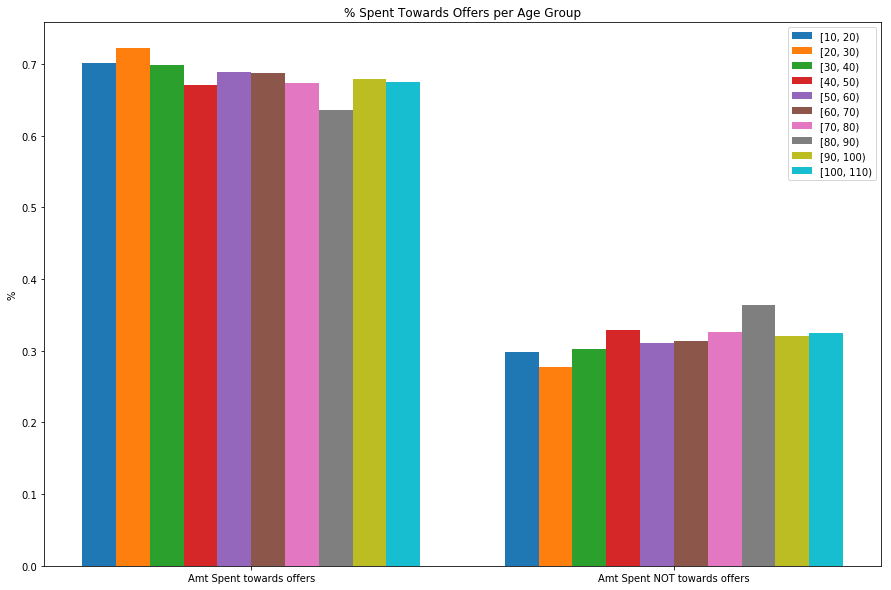

In [100]:
# Total amount spent toward offers vs. Total amount spent not in offers per age group.
def getAmtPerAgeData(age):
    """Get data for amount spent towards offers vs. amount spent not in offers per age group.
    
    Args:
        -age group (str) = One of the age groups in our data.
    
    Returns:
        -list containing percentage based on (amount spent per age group in offers / total amount spent for age group)
            and (amount spent per age group NOT in offers / total amount spent for age group).
    """
    # Initialize list to hold data for graph.
    data = []
    
    total_spent = combined.groupby(by=age)['total_amt_spent_towards_offer'].sum()[1] + combined.groupby(by=age)['amount_spent_not_in_offer'].sum()[1]
    
    for x in ['total_amt_spent_towards_offer', 'amount_spent_not_in_offer']:
        x_sum = combined.groupby(by=age)[x].sum()[1]
        
        data.append(x_sum / total_spent)
    
    return data

def graphAmtPerAgeGroup():
    """Graph total number of offers received/viewed/completed per age group.
    """
    # List of lists containing data for all age groups.
    all_data = []

    # Collect labels for legend.
    legend_labels = []
    for col in combined.columns:
        if col.startswith("age_"):
            legend_labels.append(col.split("_")[1])
            all_data.append(getAmtPerAgeData(col))

    f, ax = plt.subplots()
    f.set_figheight(10)
    f.set_figwidth(15)
    gap = .8 / len(all_data)
    for idx, row in enumerate(all_data):
        X = np.arange(len(row))
        ax.bar(X + idx * gap, row, width=gap)
        ax.legend(legend_labels)
        ax.set_title('% Spent Towards Offers per Age Group')
        ax.set_xticks(X + idx * gap / 2)
        ax.set_xticklabels(('Amt Spent towards offers', 'Amt Spent NOT towards offers'))
        ax.set_ylabel("%")

graphAmtPerAgeGroup()

Every age group spent more towards offers

In [101]:
# Every offer is sent via email, so this column can be removed since it is always 1.
combined[combined.email == 0]

Empty DataFrame
Columns: [id_customer, id_offer, num_times_received, num_times_viewed, num_times_completed, total_amt_spent_towards_offer, avg_amt_spent_towards_offer, reward, difficulty, duration, email, mobile, social, web, offer_discount, offer_informational, offer_bogo, income, membership_total_days, membership_year, age_[10, 20), age_[20, 30), age_[30, 40), age_[40, 50), age_[50, 60), age_[60, 70), age_[70, 80), age_[80, 90), age_[90, 100), age_[100, 110), gender_O, gender_M, gender_F, amount_spent_not_in_offer]
Index: []

[0 rows x 34 columns]

In [102]:
# Informational offers are never "completed". These can be dropped.
# They may or may not lead to sales, but it is hard to determine correlation.
combined[(combined.offer_informational == 1) & (combined.num_times_completed != 0)]

Empty DataFrame
Columns: [id_customer, id_offer, num_times_received, num_times_viewed, num_times_completed, total_amt_spent_towards_offer, avg_amt_spent_towards_offer, reward, difficulty, duration, email, mobile, social, web, offer_discount, offer_informational, offer_bogo, income, membership_total_days, membership_year, age_[10, 20), age_[20, 30), age_[30, 40), age_[40, 50), age_[50, 60), age_[60, 70), age_[70, 80), age_[80, 90), age_[90, 100), age_[100, 110), gender_O, gender_M, gender_F, amount_spent_not_in_offer]
Index: []

[0 rows x 34 columns]

In [103]:
combined.columns

Index(['id_customer', 'id_offer', 'num_times_received', 'num_times_viewed',
       'num_times_completed', 'total_amt_spent_towards_offer',
       'avg_amt_spent_towards_offer', 'reward', 'difficulty', 'duration',
       'email', 'mobile', 'social', 'web', 'offer_discount',
       'offer_informational', 'offer_bogo', 'income', 'membership_total_days',
       'membership_year', 'age_[10, 20)', 'age_[20, 30)', 'age_[30, 40)',
       'age_[40, 50)', 'age_[50, 60)', 'age_[60, 70)', 'age_[70, 80)',
       'age_[80, 90)', 'age_[90, 100)', 'age_[100, 110)', 'gender_O',
       'gender_M', 'gender_F', 'amount_spent_not_in_offer'],
      dtype='object')

## Preparing dataset for modeling

1. Modify data.
    - We need a column to indicate if the specific offer was "successful" or not.
    - We can drop all 'offer_informational' rows since they are never "completed".
    - Remove rows where id_offer is NaN.
    - We do not need the "id_customer" column since we want to generalize to look at the offer as a whole.
    - We do not need 'num_times_received', 'num_times_viewed', 'num_times_completed', 'membership_year'.
    - We can drop the 'email' column since it is always 1.
    - We can also drop 'amount_spent_not_in_offer' since that was only used for analysis.
    - We can drop 'avg_amt_spent_towards_offer' and 'total_amt_spent_towards_offer' since we only care that they completed the offer at least once.

2. Scale 'reward', 'difficulty', 'duration', and 'income' columns.

3. Create Train/Test/Validation sets (60/20/20)

In [104]:
print(f"The shape of combined before is {combined.shape}")

# If the offer was completed at least once, then it is successful.
combined['offer_successful'] = combined.apply(lambda row: 1 if row['num_times_completed'] else 0, axis=1)

# Drop all informational rows.
combined.drop(combined[combined.offer_informational == 1].index, inplace=True)
# Drop all rows where id_offer is NaN.
combined.drop(combined[combined.id_offer.isnull()].index, inplace=True)

# Drop the columns not needed for the model.
combined.drop(columns=['id_customer', 'num_times_received',
                       'num_times_viewed', 'num_times_completed',
                       'membership_year', 'email',
                       'offer_informational', 'amount_spent_not_in_offer',
                       'avg_amt_spent_towards_offer', 'total_amt_spent_towards_offer'],
              inplace=True, axis=1)

# Remove duplicate rows, if any exist.
combined.drop_duplicates(inplace=True)

print(f"The shape of combined after is {combined.shape}")

The shape of combined before is (69714, 34)
The shape of combined after is (44106, 25)


In [105]:
# Percent of offers that were successful
print(f"There were {combined.offer_successful.sum() / combined.offer_successful.count()}% offers that were successful.")

There were 0.6325216523828957% offers that were successful.


In [106]:
# Scale 'reward', 'difficulty', 'duration', and 'income' columns.
cols_to_scale = ['reward', 'difficulty', 'duration', 'income']

for col in cols_to_scale:
    scaler = MinMaxScaler()
    combined[col] = scaler.fit_transform(combined.loc[:, [col]])

## Save data to files so we can pick-up at building models.

In [107]:
# Delete if any existing data
!rm -rf "./formatted_data/"

if not os.path.exists("formatted_data"):
    os.mkdir("formatted_data")

combined.to_csv(os.path.join("formatted_data", "combined.csv"), index=False)

## Read in saved data

In [108]:
combined = pd.read_csv(os.path.join("formatted_data", "combined.csv"))

## Split into Training/Testing/Validation

In [109]:
# assigning seed the random generator to ensure consistent results
random_seed_1 = 3141592
random_seed_2 = 8675309

# here we are specifying which column contains the class label i.e. offer successfull or not
class_label_col = 'offer_successful'

# to split the data and class labels in order to use train_test_split.
data_no_label = combined.drop(class_label_col, axis=1)
class_labels = combined.loc[:, [class_label_col]]

# We want 80/20, and then we will split the training set into validation.
(X_train, X_test, y_train, y_test) = train_test_split(data_no_label, class_labels,
                                                      test_size=0.2, random_state=random_seed_1)

# Split into training/validation.
# To get 60/20/20 split from 80, we use a test size of 0.25 since 60/80 = 0.75.
(X_train, X_valid, y_train, y_valid) = train_test_split(X_train, y_train,
                                                      test_size=0.25, random_state=random_seed_2)

# we need to change the shape of the y values to be (n, ).
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()
y_valid = y_valid.values.ravel()

In [110]:
# Since we want to be able to create new offers to add to our portfolio, we don't want to associate
# too much importance to the exact id_offer. We want to generalize.

# Therefore, we will store the id_offer's for each training set in case we need it later.
id_offer_train = X_train.loc[:, 'id_offer']
id_offer_test = X_test.loc[:, 'id_offer']
id_offer_valid = X_valid.loc[:, 'id_offer']

# Now remove 'id_offer' from each.
X_train = X_train.drop(['id_offer'], axis=1)
X_test = X_test.drop(['id_offer'], axis=1)
X_valid = X_valid.drop(['id_offer'], axis=1)


In [111]:
X_train

reward  difficulty  duration  mobile  social  web  offer_discount  \
27585   0.375    1.000000       1.0     0.0     0.0  1.0             1.0   
27577   0.000    0.333333       0.4     1.0     0.0  1.0             1.0   
41186   0.125    0.133333       0.4     1.0     1.0  1.0             1.0   
8298    0.000    0.333333       0.4     1.0     0.0  1.0             1.0   
12549   0.125    0.133333       0.4     1.0     1.0  1.0             1.0   
...       ...         ...       ...     ...     ...  ...             ...   
18404   0.375    0.000000       0.0     1.0     1.0  1.0             0.0   
38336   0.375    0.000000       0.4     1.0     0.0  1.0             0.0   
5771    0.000    0.333333       0.4     1.0     0.0  1.0             1.0   
35272   0.375    0.000000       0.4     1.0     0.0  1.0             0.0   
36000   1.000    0.333333       0.0     1.0     1.0  1.0             0.0   

       offer_bogo    income  membership_total_days  ...  age_[40, 50)  \
27585         0.0  0.766667                   1070  ...             1   
27577         0.0  0.411111                   1060  ...             0   
41186         0.0  0.011111                    777  ...             0   
8298          0.0  0.233333                    809  ...             0   
12549         0.0  0.400000                    998  ...             0   
...           ...       ...                    ...  ...           ...   
18404         1.0  0.311111                    847  ...             1   
38336         1.0  0.377778                    916  ...             0   
5771          0.0  0.111111                    968  ...             0   
35272         1.0  0.055556                    775  ...             0   
36000         1.0  0.088889                    920  ...             1   

       age_[50, 60)  age_[60, 70)  age_[70, 80)  age_[80, 90)  age_[90, 100)  \
27585             0             0             0             0              0   
27577             0             0             0             0              0   
41186             0             0             0             0              0   
8298              1             0             0             0              0   
12549             0             0             0             0              0   
...             ...           ...           ...           ...            ...   
18404             0             0             0             0              0   
38336             0             0             0             0              0   
5771              0             1             0             0              0   
35272             0             0             1             0              0   
36000             0             0             0             0              0   

       age_[100, 110)  gender_O  gender_M  gender_F  
27585               0         0         1         0  
27577               0         0         1         0  
41186               0         0         1         0  
8298                0         0         1         0  
12549               0         0         1         0  
...               ...       ...       ...       ...  
18404               0         0         1         0  
38336               0         0         1         0  
5771                0         0         1         0  
35272               0         0         1         0  
36000               0         0         1         0  

[26463 rows x 23 columns]

In [112]:
y_train

array([1, 1, 0, ..., 1, 0, 0])

## Modeling
As we prepared the dataset, we can continue to use the model. Once again, we discuss our purpose, we wanted to analyze the drivers of the active offer, with the target variable being `offer_successful`.

As there are 3 models to offer, we may try with 3 different models to build. As we predict whether an offer will work well or not, this is a typical binary learning model.

I decided to compare the performance of a simple tree-sorting model as a basic model, with a random forest filtering model. The reason I chose the decision tree as the basic model is that I wanted to prioritize model interpretation. Going back to the objective, as we intend to analyze the importance of a feature to determine the drivers given the functionality, the decision tree can give us a good interpretation.

In the meantime, I have also chosen decisiontree classifier as an alternative to basic model modeling such as the development of simple management of logistic regression, furthering the higher accuracy of model training.

Before we continue, we must make sure the classes we predict are balanced for each data.

## Creating Models for prediction

1. Logistic Regression
2. Support Vector Machines
3. DecisionTreeClassifier

In [113]:
def f_beta_score(matrix, beta):
    """Calculate the f_beta score.
    
    Args:
        -matrix (1d array) = [tn fp fn tp]
        -beta (int) = indicates if we use F1 score, F2 score, etc.
    
    Returns:
        -score (float)
    """
    tn, fp, fn, tp = matrix
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    
    score = (1 + beta**2) * (precision * recall) / (((beta**2) * precision) + recall)
    
    return score

def f1_score(matrix):
    """Calculate F1 score"""
    return f_beta_score(matrix, 1)

def f2_score(matrix):
    """Calculate F2 score"""
    return f_beta_score(matrix, 2)


def plotConfusionMatrix(clf, X, y_true):
    """Plot the confusion matrix.
    Idea taken from plot_confusion_matrix source code in:
    https://github.com/scikit-learn/scikit-learn/blob/7e85a6d1f/sklearn/metrics/_plot/confusion_matrix.py
    
    Had to partially recreate plot_confusion_matrix because the "values_format" parameter is not
    properly passed to the ConfusionMatrixDisplay plot function.
    Opened pull request in scikit-learn GitHub to fix this.
    https://github.com/scikit-learn/scikit-learn/pull/15937
    This has been approved and will be in the upcoming scikit-learn 0.22.1 release.
    
    Args:
        -clf = classifier to plot confusion matrix for, OR Numpy Array containing confusion matrix.
    """
    if isinstance(clf, np.ndarray):
        cm = clf
        display_labels = [0, 1]
    else:
        y_pred = clf.predict(X)
        cm = confusion_matrix(y_true, y_pred)
        display_labels = clf.classes_
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    # values_format value 'n' found at https://docs.python.org/3/library/string.html#format-specification-mini-language
    # 'n' displays numbers with commas instead of scientific notation.
    disp.plot(values_format="n")
    
    return cm.flatten()
    
def plotConfusionMatrix2(clf, X, y_true):
    """Plot the confusion matrix.
    Idea taken from plot_confusion_matrix source code in:
    https://github.com/scikit-learn/scikit-learn/blob/7e85a6d1f/sklearn/metrics/_plot/confusion_matrix.py
    
    Had to partially recreate plot_confusion_matrix because the "values_format" parameter is not
    properly passed to the ConfusionMatrixDisplay plot function.
    Opened pull request in scikit-learn GitHub to fix this.
    https://github.com/scikit-learn/scikit-learn/pull/15937
    This has been approved and will be in the upcoming scikit-learn 0.22.1 release.
    
    Args:
        -clf = classifier to plot confusion matrix for, OR Numpy Array containing confusion matrix.
    """
    if isinstance(clf, np.ndarray):
        cm = clf
        display_labels = [0, 1]
    else:
        y_pred = clf.predict(X)
        cm = confusion_matrix(y_true, y_pred)
        display_labels = clf.classes_
    
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
    
    # values_format value 'n' found at https://docs.python.org/3/library/string.html#format-specification-mini-language
    # 'n' displays numbers with commas instead of scientific notation.
    disp.plot(values_format="n")
    
    return cm.flatten()

def getModelScores(clf, name=None, valid=False):
    """Plot the confusion matrix, get accuracy, f1, and f2 scores.
    
    Args:
        -clf = sklearn classifier to use, OR Numpy Array containing confusion matrix. 
        -valid (bool) = if True, then use X_valid, y_valid. Else X_test, y_test
        -name (str) = if name is provided, print the scores.
    
    Returns:
        -accuracy
        -f1
        -f2
    """
    if valid:
        X_values = X_valid
        y_values = y_valid
    else:
        X_values = X_test
        y_values = y_test
    
    # Calculate accuracy.
    if isinstance(clf, np.ndarray):
        # Accuracy = (TP + TN) / (TP + TN + FP + FN)
        acc = (clf[1][1] + clf[0][0]) / (clf.flatten().sum())
    else:
        acc = clf.score(X_values, y_values)

    # Plot the confusion matrix and get the confusion matrix.
    matrix = plotConfusionMatrix(clf, X_values, y_values)

    # Calculate the F1 score.
    f1 = f1_score(matrix)

    # Calculate the F2 score.
    f2 = f2_score(matrix)
    
    if name:
        print(f"The accuracy of the {name} model is {acc}")
        print(f"The F1 Score of the {name} model is {f1}")
        print(f"The F2 Score of the {name} model is {f2}")
    
    return acc, f1, f2

The accuracy of the baseline Logistic Regression model is 0.7140104284742689
The F1 Score of the baseline Logistic Regression model is 0.793585862717827
The F2 Score of the baseline Logistic Regression model is 0.8320181156934056


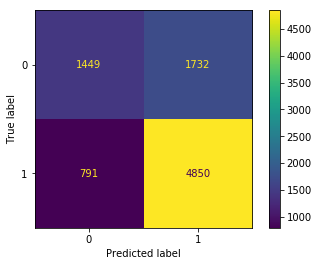

In [114]:
# Logistic Regression
logreg_clf = LogisticRegression(random_state=0, max_iter=1000).fit(X_train, y_train)

logreg_acc, logreg_f1, logreg_f2 = getModelScores(logreg_clf, name="baseline Logistic Regression")

In [115]:
!pip install scikit-plot

In [116]:
from sklearn.model_selection import cross_val_predict
import matplotlib.pyplot as plt
import scikitplot as skplt

In [117]:
predictions = cross_val_predict(logreg_clf, X_train, y_train)

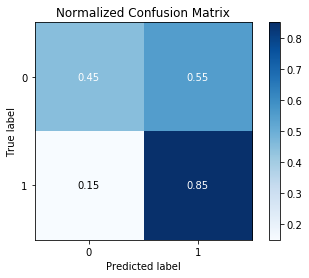

In [118]:
skplt.metrics.plot_confusion_matrix(y_train, predictions, normalize=True)
plt.show()

In [119]:
%%time
# Model 2: Support Vector Machines (SVM)
# We use the SVC version from sci-kit learn.
# SVC = C-Support Vector Classification. 
# "C" is a regularization parameter > 0. Strength of regularization = 1/C

# Let's use grid search to determine best hyperparameters.
# Idea from https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py
C_range = np.logspace(-2, 4, 10)
gamma_range = np.logspace(-9, 3, 10)
param_grid = dict(gamma=gamma_range, C=C_range)
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
grid = GridSearchCV(SVC(), param_grid=param_grid, cv=cv, verbose=100)
grid.fit(X_valid, y_valid)

print(f"These are hyperparameters are {grid.best_params_} with a score of {grid.best_score_:0.2f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   3.8s
[Parallel(n_jobs=None)]: Done   1 out of   1 | elapsed:    3.8s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   3.5s
[Parallel(n_jobs=None)]: Done   2 out of   2 | elapsed:    7.3s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   3.5s
[Parallel(n_jobs=None)]: Done   3 out of   3 | elapsed:   10.9s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 .............................................
[CV] ................. C=0.01, gamma=1e-09, score=0.632, total=   3.8s
[Parallel(n_jobs=None)]: Done   4 out of   4 | elapsed:   14.7s remaining:    0.0s
[CV] C=0.01, gamma=1e-09 ............

Output from above Grid Search:

The best hyperparameters are {'C': 10000.0, 'gamma': 1e-05} with a score of 0.73

In [123]:
#Decision tree
# Create Decision Tree classifer object
decsTree_clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
decsTree_clf = decsTree_clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = decsTree_clf.predict(X_test)

Accuracy: 0.6526864656540468
The accuracy of the Decision Tree Classifier model is 0.6526864656540468
The F1 Score of the Decision Tree Classifier model is 0.7255955579437577
The F2 Score of the Decision Tree Classifier model is 0.7211007867848624


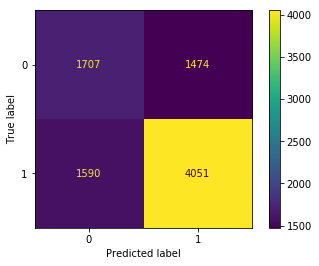

In [124]:
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
decsTree_acc, decsTree_f1, decsTree_f2 = getModelScores(decsTree_clf, name="Decision Tree Classifier")

## Conclusion

Finally, I gained some experience with this challenging project, essentially due to the dataset.

I had below questions

1. Understand demographic group or kind of customers choose the rewards or offers? 
2. What is the best offer to send to a distinct user?
3. How much will a user spend on the offer?
4. Exactly how users are accepting the offers?


## Future Improvements

If I continue to extend this project further, I would try the following:
- I will analyze the examples that were labeled as False Negatives to determine why the model incorrectly labeled them. I could then possibly apply additional feature engineering or tweak hyperparameters to reduce these.
- I will analyze usage of ensemble such as boosting and bagging and several models together to see if they improve the results.
- I am also curious if certain demographics respond more to certain offer types. This information could be used to engineer new offers targeting a specific demographic.

## References

- [Matplotlib: Bar Chart Example](https://matplotlib.org/3.1.1/gallery/units/bar_unit_demo.html)
- [Matplotlib: Pie Chart Example](https://matplotlib.org/3.1.1/gallery/pie_and_polar_charts/pie_and_donut_labels.html)
- [Matplotlib: Plotting Multiple Bar Charts](https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781849513265/1/ch01lvl1sec16/plotting-multiple-bar-charts)
- [Pandas: Move Column to Front of Table](https://stackoverflow.com/questions/25122099/move-column-by-name-to-front-of-table-in-pandas)
- [Pandas: Why Itertuples is Faster than Iterrows](https://medium.com/swlh/why-pandas-itertuples-is-faster-than-iterrows-and-how-to-make-it-even-faster-bc50c0edd30d)
- [Propensity Model: Algorithms](https://datascience.foundation/sciencewhitepaper/propensity-modelling-for-business)
- [Propensity Model: What is it?](https://www.campaignlive.co.uk/article/propensity-model/165289)
- [Scikit Learn: Logistic Regression Model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [Scikit Learn: MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
- [Scikit Learn: SVM SVC Model](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html)
- [Scikit Learn: SVM SVC Hyperparameter Tuning Example](https://scikit-learn.org/stable/auto_examples/svm/plot_rbf_parameters.html#sphx-glr-auto-examples-svm-plot-rbf-parameters-py)
- [Scikit Learn: train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
- [Wikipedia: Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision)
- [Wikipedia: Confusion Matrix](https://en.wikipedia.org/wiki/Confusion_matrix)
- [Wikipedia: F₁ Score and F₂ Score](https://en.wikipedia.org/wiki/F1_score)
- [Wikipedia: Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall)